In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

import yaml

In [38]:
predictions_dict = {}

In [39]:
config_filename = 'weights.yaml'
config = read_config(config_filename)

In [40]:
config

{&#39;fitting&#39;: {&#39;data&#39;: {&#39;data_source&#39;: &#39;covid19india&#39;,
   &#39;stratified_data&#39;: False,
   &#39;dataloading_params&#39;: {&#39;state&#39;: &#39;Jharkhand&#39;,
    &#39;district&#39;: &#39;Ranchi&#39;,
    &#39;use_dataframe&#39;: &#39;data_all&#39;},
   &#39;smooth_jump&#39;: False,
   &#39;smooth_jump_params&#39;: None,
   &#39;rolling_average&#39;: True,
   &#39;rolling_average_params&#39;: {&#39;center&#39;: True,
    &#39;window_size&#39;: 7,
    &#39;win_type&#39;: None,
    &#39;min_periods&#39;: 3,
    &#39;split_after_rolling&#39;: False}},
  &#39;model&#39;: models.seir.seirhd.SEIRHD,
  &#39;variable_param_ranges&#39;: {&#39;lockdown_R0&#39;: [[0.7, 1.8], &#39;uniform&#39;],
   &#39;T_inc&#39;: [[4, 5], &#39;uniform&#39;],
   &#39;T_inf&#39;: [[3, 4], &#39;uniform&#39;],
   &#39;T_recov&#39;: [[0, 40], &#39;uniform&#39;],
   &#39;T_recov_fatal&#39;: [[0, 40], &#39;uniform&#39;],
   &#39;P_fatal&#39;: [[0, 0.1], &#39;uniform&#39;],
   &#39;E_h

In [41]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_01102020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 104                 | 105                 | 106                 | 107                 | 108                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-09 00:00:00 | 2020-08-10 00:00:00 | 2020-08-11 00:00:00 | 2020-08-12 00:00:00 | 2020-08-13 00:00:00 |
| state       | Jharkhand           | Jharkhand           | Jharkhand           | Jharkhand           | Jharkhand           |
| district    | Ranchi              | Ranchi              | Ranchi              | Ranchi              | Ranchi              |
| total       | 3521.14             | 3664.71             | 3750.33             | 3808.6              | 3852.25    

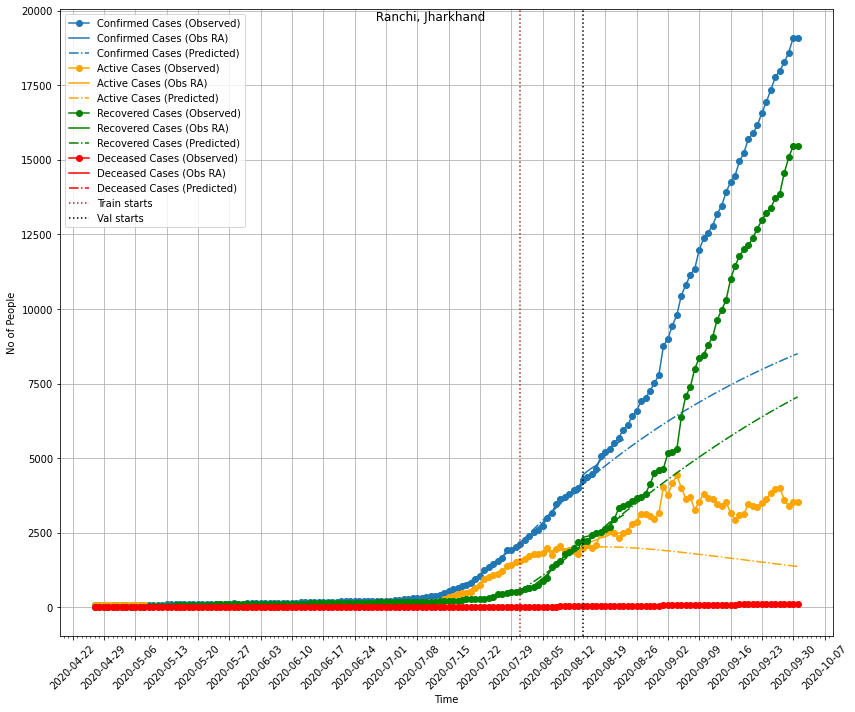

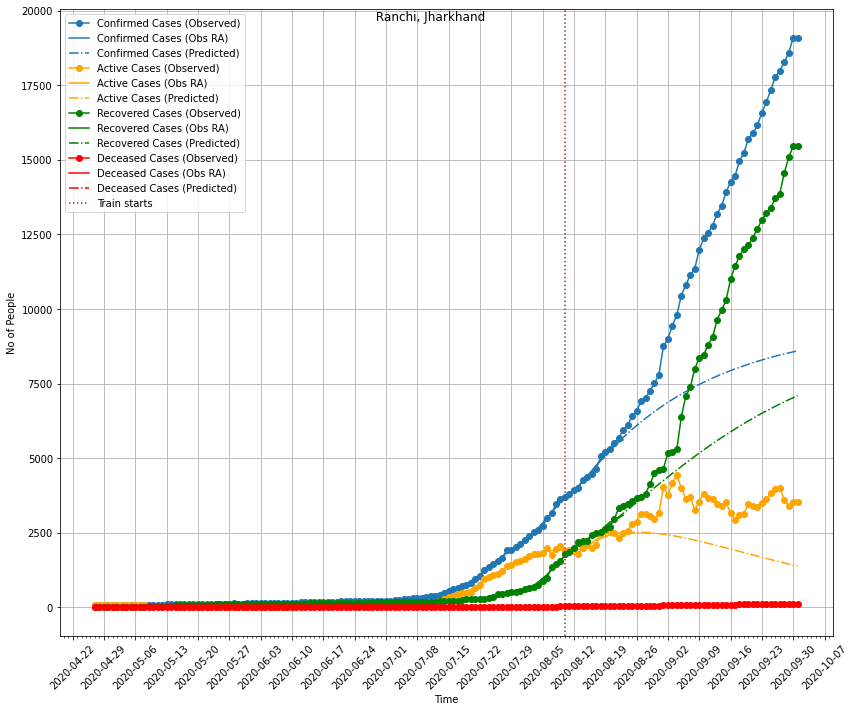

In [42]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [43]:
predictions_dict['m1']['best_params']

{&#39;E_hosp_ratio&#39;: 0.46076552034714735,
 &#39;I_hosp_ratio&#39;: 0.3784520802427599,
 &#39;P_fatal&#39;: 0.009649540350787042,
 &#39;T_inc&#39;: 4.824114938867573,
 &#39;T_inf&#39;: 3.927499163468048,
 &#39;T_recov&#39;: 16.94159252112754,
 &#39;T_recov_fatal&#39;: 25.772932724584216,
 &#39;lockdown_R0&#39;: 0.8794095138036864}

In [44]:
predictions_dict['m2']['best_params']

{&#39;E_hosp_ratio&#39;: 0.7171892659767041,
 &#39;I_hosp_ratio&#39;: 0.14236979149182644,
 &#39;P_fatal&#39;: 0.020771145443784368,
 &#39;T_inc&#39;: 4.331355348570781,
 &#39;T_inf&#39;: 3.782512183939133,
 &#39;T_recov&#39;: 19.86421056998785,
 &#39;T_recov_fatal&#39;: 34.814135179684705,
 &#39;lockdown_R0&#39;: 0.7234593379437214}

## Loss Dataframes

### M1 Loss DataFrame

In [45]:
predictions_dict['m1']['df_loss']

,train,val
total,3.03089,6.97872
active,3.86867,12.1119
recovered,12.0022,3.96949
deceased,3.37043,11.5199


### M2 Loss DataFrame

In [46]:
predictions_dict['m2']['df_loss']

,train
total,1.85159
active,5.04886
recovered,3.57594
deceased,2.45414


## Sensitivity Plot

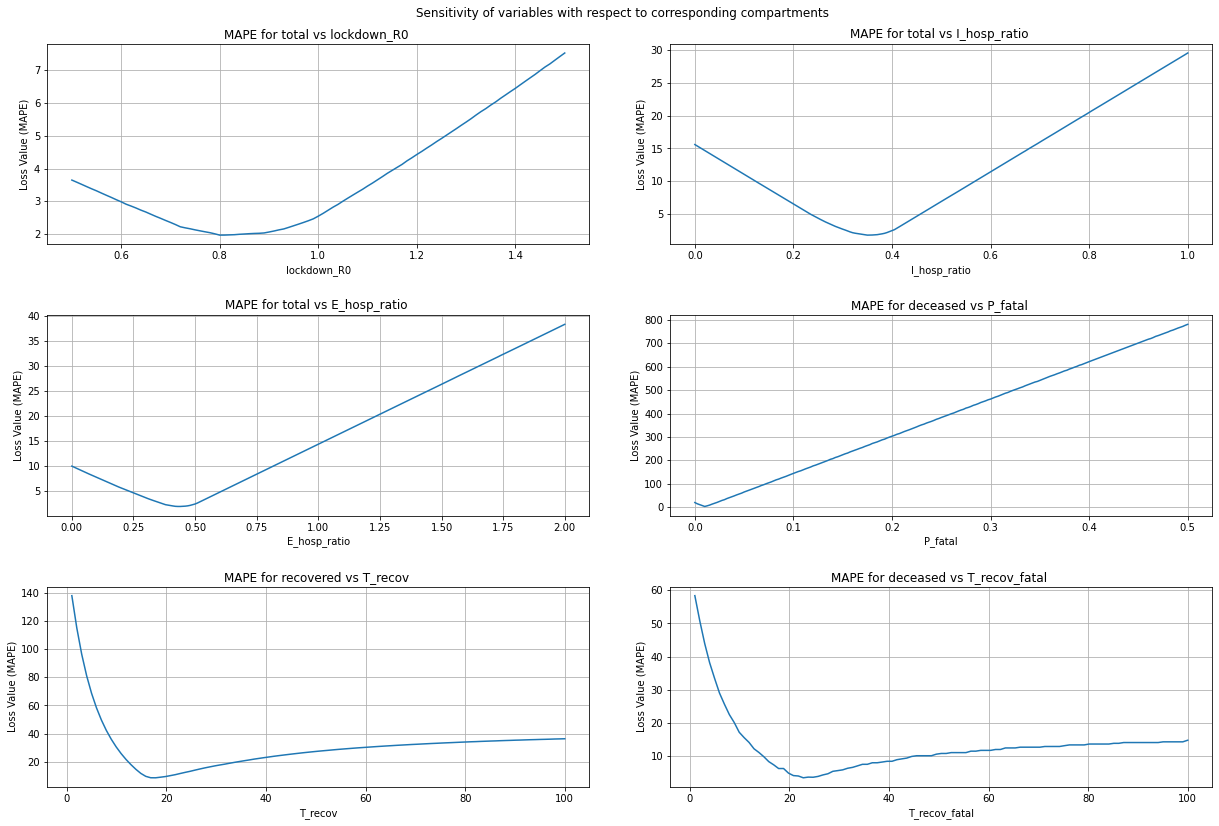

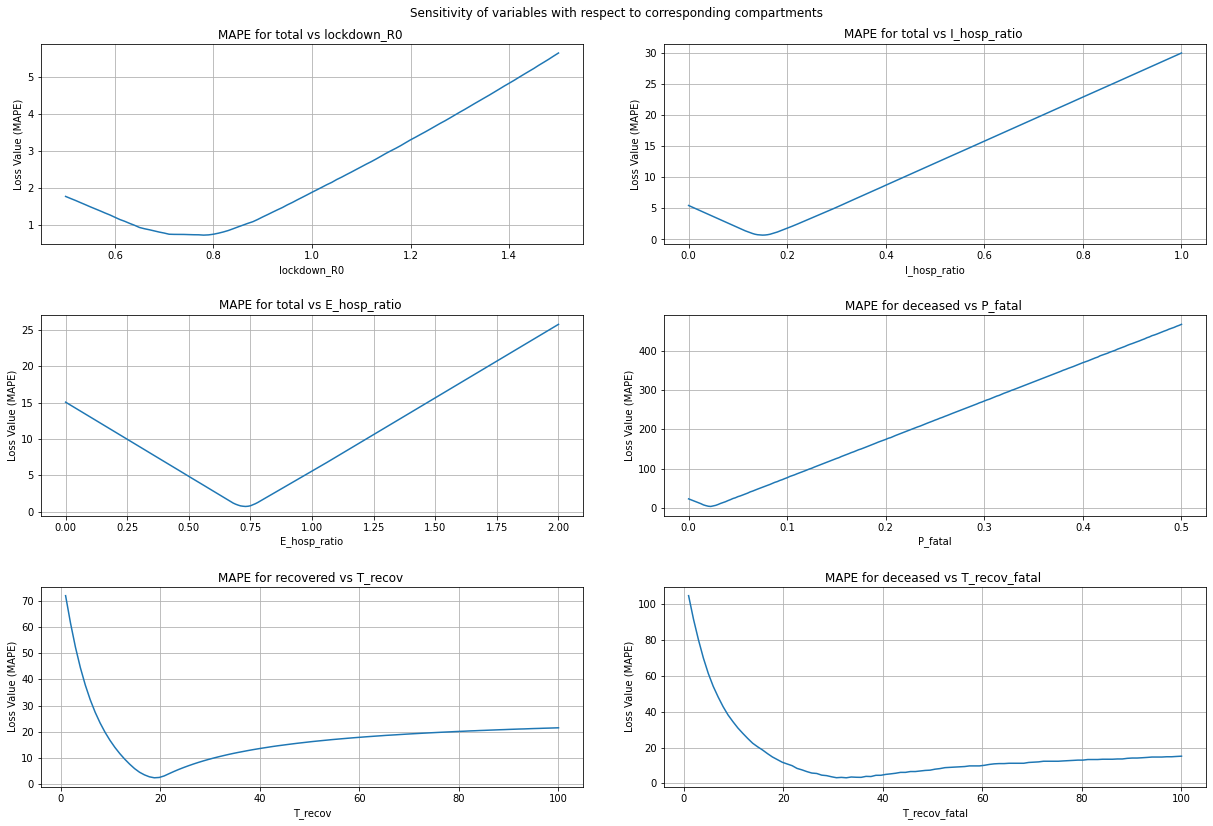

In [47]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [48]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


[         date        S     E    I  R_recov  R_fatal     C    D  active  \
0  2020-08-10  1394705  1359  269     1856       39  1736   31    1895   
1  2020-08-11  1394634  1143  458     1860       40  1830   32    1900   
2  2020-08-12  1394535   996  567     1899       41  1924   33    1940   
3  2020-08-13  1394421   893  626     1958       44  2021   35    2002   
4  2020-08-14  1394298   818  653     2024       46  2122   36    2070   
..        ...      ...   ...  ...      ...      ...   ...  ...     ...   
93 2020-11-11  1390657    26   26      389       23  8712  164     412   
94 2020-11-12  1390652    25   25      377       22  8731  165     399   
95 2020-11-13  1390647    24   24      365       22  8750  165     387   
96 2020-11-14  1390642    23   23      353       21  8768  166     374   
97 2020-11-15  1390638    22   23      342       21  8785  167     363   

    recovered  deceased  total  
0        1736        31   3662  
1        1830        32   3762  
2        19

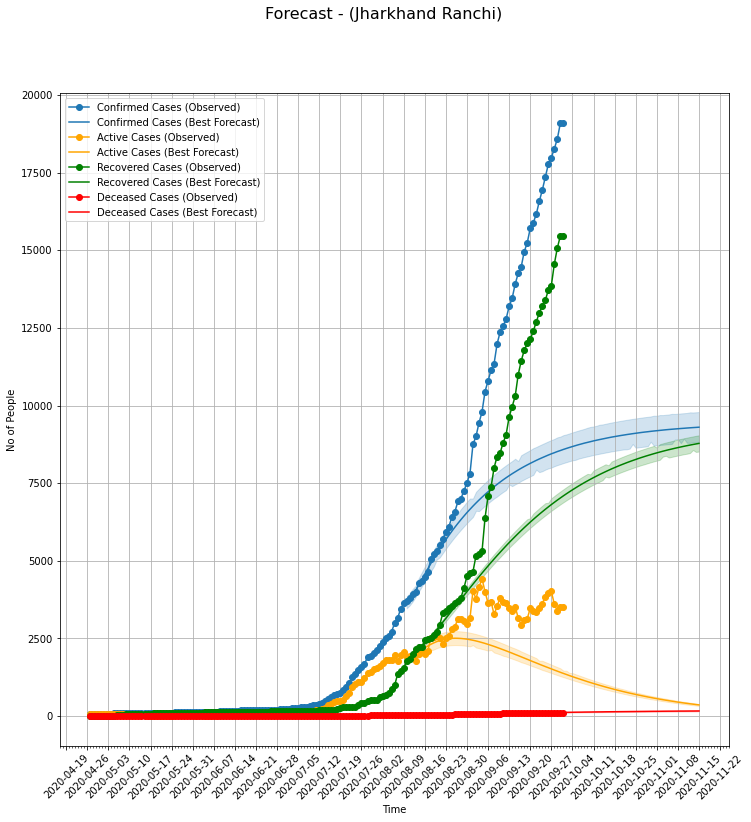

In [49]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True)

In [50]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

12it [00:00, 119.49it/s]getting forecasts ..
1000it [00:09, 104.75it/s]


In [51]:
predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

11it [00:00, 107.67it/s]getting forecasts ..
1000it [00:09, 104.35it/s]


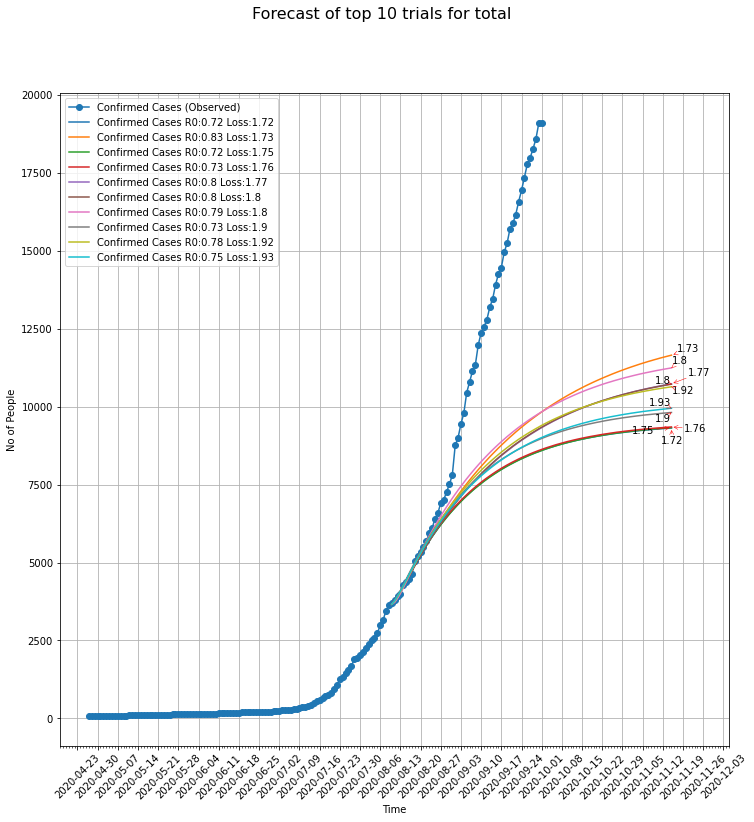

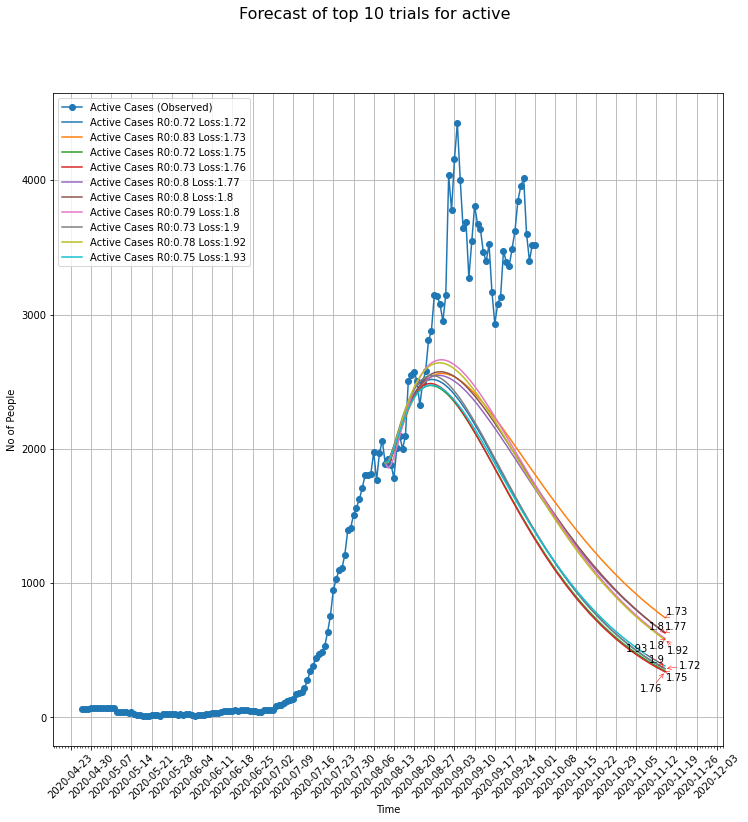

In [52]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])

In [53]:
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [54]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:48&lt;00:00,  2.05trial/s, best loss: 3.5730578797811297]


In [55]:
uncertainty.beta_loss

{&#39;active&#39;: 6.803773163639508,
 &#39;recovered&#39;: 3.6868034329405774,
 &#39;deceased&#39;: 1.6207823937398154,
 &#39;total&#39;: 2.1808725288046173}

In [56]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [57]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

[         date        S     E    I  R_recov  R_fatal     C    D  active  \
0  2020-08-10  1394705  1359  269     1856       39  1736   31    1895   
1  2020-08-11  1394634  1143  458     1860       40  1830   32    1900   
2  2020-08-12  1394535   996  567     1899       41  1924   33    1940   
3  2020-08-13  1394421   893  626     1958       44  2021   35    2002   
4  2020-08-14  1394298   818  653     2024       46  2122   36    2070   
..        ...      ...   ...  ...      ...      ...   ...  ...     ...   
93 2020-11-11  1390657    26   26      389       23  8712  164     412   
94 2020-11-12  1390652    25   25      377       22  8731  165     399   
95 2020-11-13  1390647    24   24      365       22  8750  165     387   
96 2020-11-14  1390642    23   23      353       21  8768  166     374   
97 2020-11-15  1390638    22   23      342       21  8785  167     363   

    recovered  deceased  total  
0        1736        31   3662  
1        1830        32   3762  
2        19

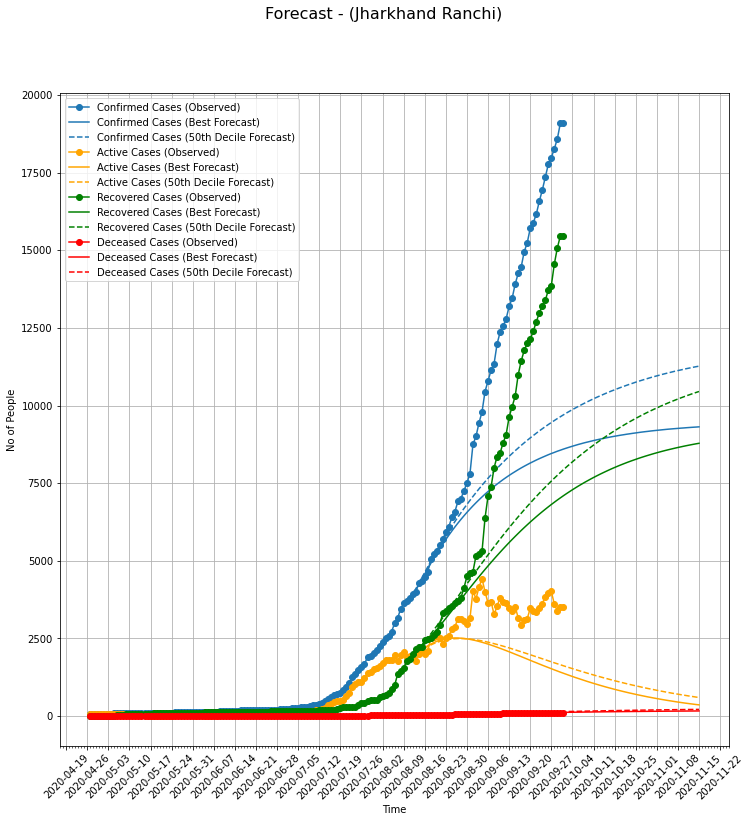

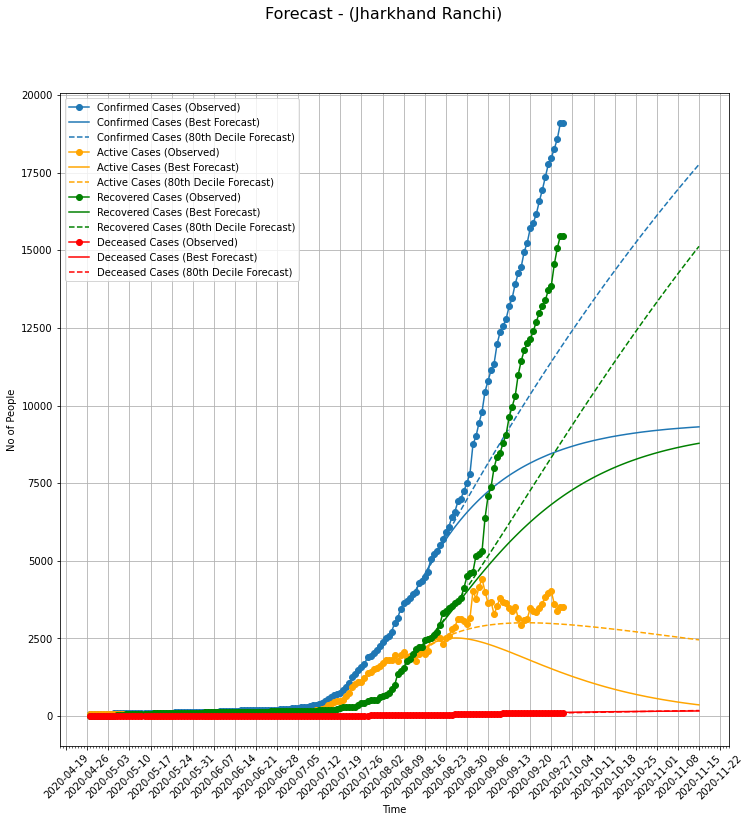

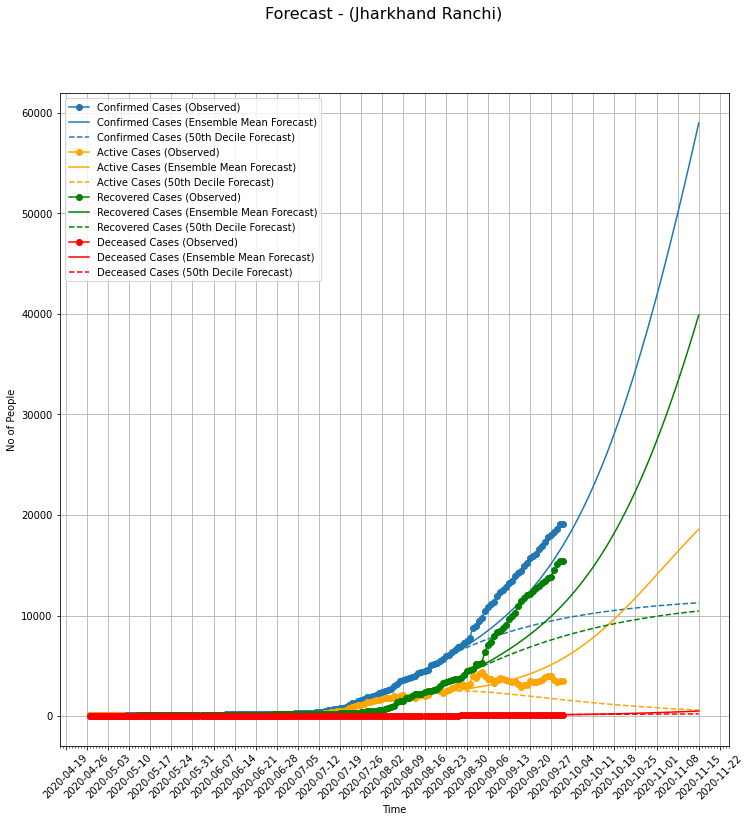

In [58]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

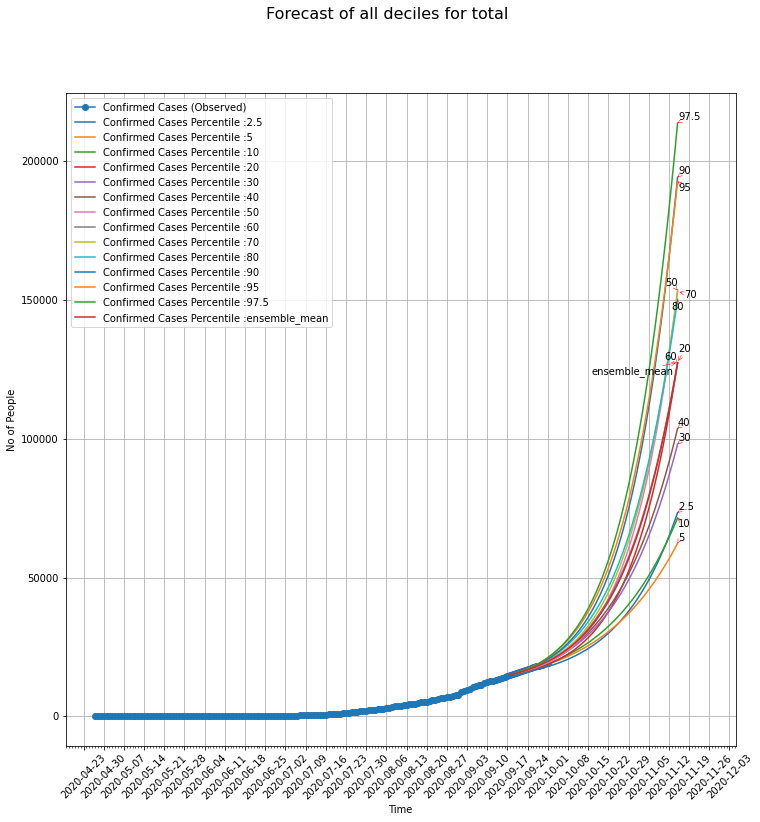

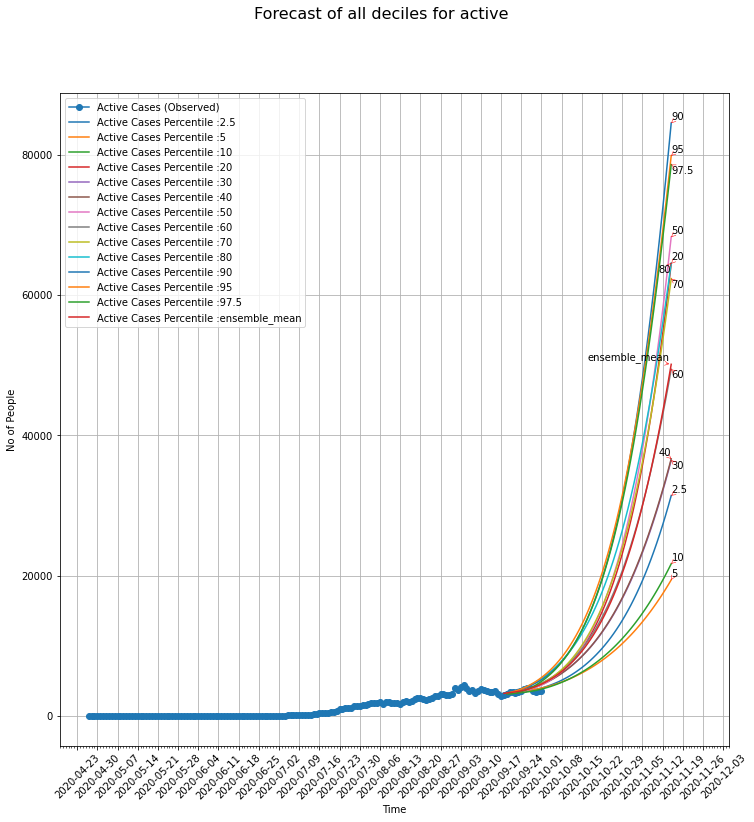

In [24]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## Create Report

In [25]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [26]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [27]:
#log_wandb(predictions_dict)

## Create All Trials Output

In [28]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Experiments

In [59]:
predictions_dict['m1'].keys()

dict_keys([&#39;plots&#39;, &#39;best_params&#39;, &#39;default_params&#39;, &#39;variable_param_ranges&#39;, &#39;optimiser&#39;, &#39;df_prediction&#39;, &#39;df_district&#39;, &#39;df_train&#39;, &#39;df_val&#39;, &#39;df_loss&#39;, &#39;trials&#39;, &#39;data_last_date&#39;, &#39;df_district_unsmoothed&#39;, &#39;run_params&#39;, &#39;trials_processed&#39;])

In [60]:
predictions_dict['m2'].keys()

dict_keys([&#39;plots&#39;, &#39;best_params&#39;, &#39;default_params&#39;, &#39;variable_param_ranges&#39;, &#39;optimiser&#39;, &#39;df_prediction&#39;, &#39;df_district&#39;, &#39;df_train&#39;, &#39;df_val&#39;, &#39;df_loss&#39;, &#39;trials&#39;, &#39;data_last_date&#39;, &#39;df_district_unsmoothed&#39;, &#39;run_params&#39;, &#39;forecasts&#39;, &#39;trials_processed&#39;, &#39;beta&#39;, &#39;beta_loss&#39;, &#39;deciles&#39;])

In [61]:
predictions_dict['m1']['df_district']

,date,state,district,total,active,recovered,deceased,tested,other,daily_cases
0,2020-04-27,Jharkhand,Ranchi,75,63,10,2,NaN,NaN,20.0
1,2020-04-28,Jharkhand,Ranchi,77,65,10,2,NaN,NaN,2.0
2,2020-04-29,Jharkhand,Ranchi,78,66,10,2,NaN,NaN,1.0
3,2020-04-30,Jharkhand,Ranchi,81,69,10,2,NaN,NaN,3.0
4,2020-05-01,Jharkhand,Ranchi,83,71,10,2,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...
153,2020-09-27,Jharkhand,Ranchi,17985,4015,13865,105,NaN,NaN,214.0
154,2020-09-28,Jharkhand,Ranchi,18271,3603,14561,107,NaN,NaN,286.0
155,2020-09-29,Jharkhand,Ranchi,18590,3400,15078,112,NaN,NaN,319.0
156,2020-09-30,Jharkhand,Ranchi,19097,3521,15463,113,NaN,NaN,507.0


In [62]:
predictions_dict['m1']['df_train']

,date,state,district,total,active,recovered,deceased,tested,other,daily_cases
0,2020-04-27,Jharkhand,Ranchi,77.750000,65.750000,10.000000,2.000000,NaN,NaN,6.500000
1,2020-04-28,Jharkhand,Ranchi,78.800000,66.800000,10.000000,2.000000,NaN,NaN,5.600000
2,2020-04-29,Jharkhand,Ranchi,79.500000,67.500000,10.000000,2.000000,NaN,NaN,4.666667
3,2020-04-30,Jharkhand,Ranchi,80.000000,67.571429,10.428571,2.000000,NaN,NaN,4.000000
4,2020-05-01,Jharkhand,Ranchi,81.142857,68.285714,10.857143,2.000000,NaN,NaN,1.142857
...,...,...,...,...,...,...,...,...,...,...
104,2020-08-09,Jharkhand,Ranchi,3521.142857,1923.857143,1566.857143,30.428571,NaN,NaN,170.571429
105,2020-08-10,Jharkhand,Ranchi,3664.714286,1896.285714,1736.857143,31.571429,NaN,NaN,143.571429
106,2020-08-11,Jharkhand,Ranchi,3750.333333,1917.833333,1800.333333,32.166667,NaN,NaN,140.833333
107,2020-08-12,Jharkhand,Ranchi,3808.600000,1907.200000,1868.400000,33.000000,NaN,NaN,107.400000


In [63]:
predictions_dict['m1']['df_val']

,date,state,district,total,active,recovered,deceased,tested,other,daily_cases
109,2020-08-14,Jharkhand,Ranchi,4438.000000,2049.500000,2349.000000,39.500000,NaN,NaN,159.250000
110,2020-08-15,Jharkhand,Ranchi,4562.200000,2141.000000,2381.200000,40.000000,NaN,NaN,212.600000
111,2020-08-16,Jharkhand,Ranchi,4670.000000,2209.333333,2420.000000,40.666667,NaN,NaN,202.166667
112,2020-08-17,Jharkhand,Ranchi,4763.285714,2261.571429,2460.428571,41.285714,NaN,NaN,189.571429
113,2020-08-18,Jharkhand,Ranchi,4939.142857,2333.000000,2563.428571,42.714286,NaN,NaN,175.857143
114,2020-08-19,Jharkhand,Ranchi,5128.285714,2365.142857,2718.714286,44.428571,NaN,NaN,189.142857
115,2020-08-20,Jharkhand,Ranchi,5336.428571,2436.428571,2854.428571,45.571429,NaN,NaN,208.142857
116,2020-08-21,Jharkhand,Ranchi,5453.666667,2493.666667,2913.666667,46.333333,NaN,NaN,217.333333
117,2020-08-22,Jharkhand,Ranchi,5532.600000,2491.000000,2994.400000,47.200000,NaN,NaN,175.600000
118,2020-08-23,Jharkhand,Ranchi,5613.500000,2476.000000,3089.500000,48.000000,NaN,NaN,182.000000


In [64]:
predictions_dict['m1']['df_prediction']

,date,S,E,I,R_recov,R_fatal,C,D,active,recovered,deceased,total
0,2020-07-31,1396513,724,594,1556,15,571,23,1571,571,23,2165
1,2020-08-01,1396380,708,592,1613,16,664,24,1629,664,24,2317
2,2020-08-02,1396248,694,587,1665,16,761,25,1681,761,25,2467
3,2020-08-03,1396118,682,581,1712,17,861,25,1729,861,25,2615
4,2020-08-04,1395989,671,574,1756,18,963,26,1774,963,26,2763
...,...,...,...,...,...,...,...,...,...,...,...,...
58,2020-09-27,1391188,301,260,1422,21,6728,76,1443,6728,76,8247
59,2020-09-28,1391130,297,256,1404,21,6811,76,1425,6811,76,8312
60,2020-09-29,1391073,292,253,1386,21,6894,77,1407,6894,77,8378
61,2020-09-30,1391018,288,249,1368,21,6975,78,1389,6975,78,8442


In [65]:
predictions_dict['m2']['df_district']

,date,state,district,total,active,recovered,deceased,tested,other,daily_cases
0,2020-04-27,Jharkhand,Ranchi,75,63,10,2,NaN,NaN,20.0
1,2020-04-28,Jharkhand,Ranchi,77,65,10,2,NaN,NaN,2.0
2,2020-04-29,Jharkhand,Ranchi,78,66,10,2,NaN,NaN,1.0
3,2020-04-30,Jharkhand,Ranchi,81,69,10,2,NaN,NaN,3.0
4,2020-05-01,Jharkhand,Ranchi,83,71,10,2,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...
153,2020-09-27,Jharkhand,Ranchi,17985,4015,13865,105,NaN,NaN,214.0
154,2020-09-28,Jharkhand,Ranchi,18271,3603,14561,107,NaN,NaN,286.0
155,2020-09-29,Jharkhand,Ranchi,18590,3400,15078,112,NaN,NaN,319.0
156,2020-09-30,Jharkhand,Ranchi,19097,3521,15463,113,NaN,NaN,507.0


In [66]:
predictions_dict['m2']['df_district']

,date,state,district,total,active,recovered,deceased,tested,other,daily_cases
0,2020-04-27,Jharkhand,Ranchi,75,63,10,2,NaN,NaN,20.0
1,2020-04-28,Jharkhand,Ranchi,77,65,10,2,NaN,NaN,2.0
2,2020-04-29,Jharkhand,Ranchi,78,66,10,2,NaN,NaN,1.0
3,2020-04-30,Jharkhand,Ranchi,81,69,10,2,NaN,NaN,3.0
4,2020-05-01,Jharkhand,Ranchi,83,71,10,2,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...
153,2020-09-27,Jharkhand,Ranchi,17985,4015,13865,105,NaN,NaN,214.0
154,2020-09-28,Jharkhand,Ranchi,18271,3603,14561,107,NaN,NaN,286.0
155,2020-09-29,Jharkhand,Ranchi,18590,3400,15078,112,NaN,NaN,319.0
156,2020-09-30,Jharkhand,Ranchi,19097,3521,15463,113,NaN,NaN,507.0


In [74]:
set(predictions_dict['m2']['df_prediction'].date).difference(set(predictions_dict['m2']['df_train'].date))

{Timestamp(&#39;2020-08-24 00:00:00&#39;),
 Timestamp(&#39;2020-08-25 00:00:00&#39;),
 Timestamp(&#39;2020-08-26 00:00:00&#39;),
 Timestamp(&#39;2020-08-27 00:00:00&#39;),
 Timestamp(&#39;2020-08-28 00:00:00&#39;),
 Timestamp(&#39;2020-08-29 00:00:00&#39;),
 Timestamp(&#39;2020-08-30 00:00:00&#39;),
 Timestamp(&#39;2020-08-31 00:00:00&#39;),
 Timestamp(&#39;2020-09-01 00:00:00&#39;),
 Timestamp(&#39;2020-09-02 00:00:00&#39;),
 Timestamp(&#39;2020-09-03 00:00:00&#39;),
 Timestamp(&#39;2020-09-04 00:00:00&#39;),
 Timestamp(&#39;2020-09-05 00:00:00&#39;),
 Timestamp(&#39;2020-09-06 00:00:00&#39;),
 Timestamp(&#39;2020-09-07 00:00:00&#39;),
 Timestamp(&#39;2020-09-08 00:00:00&#39;),
 Timestamp(&#39;2020-09-09 00:00:00&#39;),
 Timestamp(&#39;2020-09-10 00:00:00&#39;),
 Timestamp(&#39;2020-09-11 00:00:00&#39;),
 Timestamp(&#39;2020-09-12 00:00:00&#39;),
 Timestamp(&#39;2020-09-13 00:00:00&#39;),
 Timestamp(&#39;2020-09-14 00:00:00&#39;),
 Timestamp(&#39;2020-09-15 00:00:00&#39;),
 Timestamp(